In [67]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel, LlamaTokenizer
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)


In [68]:
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [69]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [70]:
# from google.colab import drive
# drive.mount('/content/drive')

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [72]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

fatal: destination path 'TextGraphs17-shared-task' already exists and is not an empty directory.


In [73]:
!ls TextGraphs17-shared-task

baselines  evaluation		    README.md	   submission_example
data	   question_graph_examples  reformat_data  visualization


In [74]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"
test_path = "TextGraphs17-shared-task/data/tsv/test.tsv"

train_dev_df = pd.read_csv(train_dev_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

In [75]:
train_dev_questions = list(train_dev_df["question"].unique())
test_questions = list(test_df["question"].unique())
num_train_dev_questions = len(train_dev_questions)
random.shuffle(train_dev_questions)

### Splitting train into train/dev

In [76]:
train_ratio = 0.9

num_train_questions = int(num_train_dev_questions * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(test_questions)}")

Questions: train - 3181, dev - 354, test - 1000


In [77]:
train_df = train_dev_df[train_dev_df["question"].isin(train_questions)]
dev_df = train_dev_df[train_dev_df["question"].isin(dev_questions)]


print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (33911, 10)
Dev: (3761, 10)
Test: (10961, 7)


In [78]:
train_df.loc[0, "graph"]

'{\'nodes\': [{\'type\': \'QUESTIONS_ENTITY\', \'name_\': \'Q794\', \'id\': 0, \'label\': \'Iran\'}, {\'type\': \'INTERNAL\', \'name_\': \'Q207991\', \'id\': 1, \'label\': \'Pahlavi dynasty\'}, {\'type\': \'ANSWER_CANDIDATE_ENTITY\', \'name_\': \'Q7293530\', \'id\': 2, \'label\': "Ruhollah Khomeini\'s return to Iran"}], \'links\': [{\'name_\': \'P17\', \'source\': 0, \'target\': 0, \'label\': \'country\'}, {\'name_\': \'P1365\', \'source\': 0, \'target\': 1, \'label\': \'replaces\'}, {\'name_\': \'P1366\', \'source\': 1, \'target\': 0, \'label\': \'replaced by\'}, {\'name_\': \'P17\', \'source\': 2, \'target\': 1, \'label\': \'country\'}]}'

In [79]:
train_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [80]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = np.zeros(shape=test_df.shape[0], dtype=np.float32)
train_df["label"].head(5)

/tmp/ipykernel_5299/3709585686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
/tmp/ipykernel_5299/3709585686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [81]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

/tmp/ipykernel_5299/1764180835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
/tmp/ipykernel_5299/1764180835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)


In [82]:
train_df.loc[0, "graph"]

{'nodes': [{'type': 'QUESTIONS_ENTITY',
   'name_': 'Q794',
   'id': 0,
   'label': 'Iran'},
  {'type': 'INTERNAL',
   'name_': 'Q207991',
   'id': 1,
   'label': 'Pahlavi dynasty'},
  {'type': 'ANSWER_CANDIDATE_ENTITY',
   'name_': 'Q7293530',
   'id': 2,
   'label': "Ruhollah Khomeini's return to Iran"}],
 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'},
  {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'},
  {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'},
  {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}

In [83]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whst is the name of the head of state and high...,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,0.0
1,Whst is the name of the head of state and high...,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,0.0
2,Whst is the name of the head of state and high...,Ruhollah Khomeini,Office of the Supreme Leader of Iran,0.0
3,Whst is the name of the head of state and high...,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,1.0
4,Whst is the name of the head of state and high...,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,0.0
5,Whst is the name of the head of state and high...,Mahmoud Ahmadinejad,Office of the Supreme Leader of Iran,0.0
6,Whst is the name of the head of state and high...,Hassan Rouhani,Office of the Supreme Leader of Iran,0.0
7,Whst is the name of the head of state and high...,Ayatollah Khamenei's Foreign Policy Orientation,Office of the Supreme Leader of Iran,0.0
8,Whst is the name of the head of state and high...,Ayatollah Ali Khamenei speaks about Iranian pr...,Office of the Supreme Leader of Iran,0.0
9,Whst is the name of the head of state and high...,Ali Khamenei bibliography,Office of the Supreme Leader of Iran,0.0


In [84]:
test_df[["question", "answerEntity"]].head(10)

,question,answerEntity
0,"After publishing A Time to Kill, which book di...",A Clash of Kings
1,"After publishing A Time to Kill, which book di...",A Feast for Crows
2,"After publishing A Time to Kill, which book di...",Fear and Loathing in Las Vegas
3,"After publishing A Time to Kill, which book di...",In Cold Blood
4,"After publishing A Time to Kill, which book di...",Into the Woods
5,"After publishing A Time to Kill, which book di...",Kongenes kamp
6,"After publishing A Time to Kill, which book di...",No Country for Old Men
7,"After publishing A Time to Kill, which book di...",No Country for Old Men
8,"After publishing A Time to Kill, which book di...",Slaughterhouse-Five
9,"After publishing A Time to Kill, which book di...",The Firm


In [85]:
class QuestionAnswerDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first"):
        super(QuestionAnswerDataset, self).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    # def __getitem__(self, idx):
    #     source_ids = self.tokenized_input[idx]["input_ids"].squeeze()
    #     source_mask = self.tokenized_input[idx]["attention_mask"].squeeze()
    #     labels = self.labels[idx].unsqueeze(0)
    #     if torch.isnan(labels).any():
    #         labels[torch.isnan(labels)] = 0
    #     target_mask = torch.ones_like(labels)

    #     # Shift the target_ids one position to the right to create the decoder_input_ids
    #     decoder_input_ids = torch.cat([torch.tensor([self.tokenizer.bos_token_id]), labels[:-1]], dim=-1)
    #     decoder_attention_mask = torch.ones_like(decoder_input_ids)

    #     return {
    #         "input_ids": source_ids,
    #         "attention_mask": source_mask,
    #         "decoder_input_ids": decoder_input_ids,
    #         "decoder_attention_mask": decoder_attention_mask,
    #         "labels": labels
    #     }

    def __getitem__(self, idx):
        labels = self.labels[idx] #target_ids
        if labels.ndim == 0:
            #print(labels)
            # If the label is a scalar, convert it to a 1-dimensional tensor
            labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)
            labels = labels.unsqueeze(0)
        # need target_mask
        target_mask = torch.zeros_like(labels)


        return {
                "input_ids": self.tokenized_input[idx]["input_ids"].squeeze(),
                "attention_mask" : self.tokenized_input[idx]["attention_mask"].squeeze(),
                "labels": labels,
                "target_mask": target_mask}


In [86]:
# model_name="roberta-base"
# model_name="sentence-transformers/all-mpnet-base-v2"
#model_name="meta-llama/Llama-2-7b-hf"

tokenizer = T5Tokenizer.from_pretrained("t5-base")
#tokenizer = LlamaTokenizer.from_pretrained(model_name)
bert_model = T5ForConditionalGeneration.from_pretrained("t5-base")

# freeze_embeddings = True
# if freeze_embeddings:
#     for param in bert_model.embeddings.parameters():
#         param.requires_grad = False

# freeze_layer_count = 5
# if freeze_layer_count > 0:
#     for layer in bert_model.encoder.layer[:freeze_layer_count]:
#         for param in layer.parameters():
#             param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Trainable params:  222903552


In [87]:
train_df_filtered = train_df.copy()
train_df_filtered.sort_values(by=["label", ], ascending=False, inplace=True)
train_df_filtered["label"].head()

28718    1.0
32762    1.0
23799    1.0
15376    1.0
15381    1.0
Name: label, dtype: float32

In [88]:
print(train_df_filtered.shape)
train_df_filtered.drop_duplicates(subset=["question", "answerEntity"], keep="first", inplace=True)
print(train_df_filtered.shape)

(33911, 11)
(31780, 11)


In [89]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df_filtered, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [90]:
idx_bound = 2
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = dev_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = test_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    print('---')

 ▁What ▁was ▁the ▁first ▁Mario ▁game ▁to ▁feature ▁Yo shi ? </s> ▁Super ▁Mario ▁World </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 ▁Who s e ▁as s assi n ation ▁ s parked ▁the ▁beginning ▁of ▁World ▁War ▁I ? </s> ▁as s assi n ation ▁of ▁Arch du ke ▁Franz ▁Ferdinand </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

/tmp/ipykernel_5299/654079615.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32).clone().detach()#.requires_grad_(True)


In [91]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [92]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [93]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [94]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs,  checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [95]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [96]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [97]:
class LlamaSimpleClassifier(nn.Module):
    def __init__(self, llama_model, dropout=0.1):
        super().__init__()

        self.llama_model = llama_model
        self.dropout = nn.Dropout(p=dropout)
        llama_hidden_dim = llama_model.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(llama_hidden_dim, llama_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(llama_hidden_dim, 1),
        )

    def forward(self, inputs, attention_mask):
        outputs = self.llama_model(inputs, attention_mask=attention_mask, return_dict=True)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        proba = self.classifier(pooled_output)
        return proba

In [98]:
N_EPOCHS = 5
DROPOUT = 0.2

In [99]:
bert_simple_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
# bert_simple_clf = LlamaSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss().to(device)

DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "../aten/src/ATen/cuda/CUDAContext.cpp":50, please report a bug to PyTorch. 

CUDA call was originally invoked at:

['  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/runpy.py", line 197, in _run_module_as_main\n    return _run_code(code, main_globals, None,\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/runpy.py", line 87, in _run_code\n    exec(code, run_globals)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>\n    app.launch_new_instance()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/traitlets/config/application.py", line 1053, in launch_instance\n    app.start()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 737, in start\n    self.io_loop.start()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start\n    self.asyncio_loop.run_forever()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/asyncio/base_events.py", line 601, in run_forever\n    self._run_once()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once\n    handle._run()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/asyncio/events.py", line 80, in _run\n    self._context.run(self._callback, *self._args)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue\n    await self.process_one()\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in process_one\n    await dispatch(*args)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell\n    await result\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 758, in execute_request\n    reply_content = await reply_content\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 426, in do_execute\n    res = shell.run_cell(\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell\n    return super().run_cell(*args, **kwargs)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell\n    result = self._run_cell(\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell\n    result = runner(coro)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner\n    coro.send(None)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async\n    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes\n    if await self.run_code(code, result, async_=asy):\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n', '  File "/tmp/ipykernel_5299/1089758286.py", line 2, in <module>\n    from torch.utils.data import Dataset\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 972, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 850, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/torch/__init__.py", line 1146, in <module>\n    _C._initExtension(manager_path())\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 850, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/torch/cuda/__init__.py", line 197, in <module>\n    _lazy_call(_check_capability)\n', '  File "/home/zwanggy/anaconda3/envs/abs_unlock/lib/python3.9/site-packages/torch/cuda/__init__.py", line 195, in _lazy_call\n    _queued_calls.append((callable, traceback.format_stack()))\n']

In [ ]:
class_counts = train_df["label"].value_counts()
pos_weight = class_counts[0] / class_counts[1]

pos_weight = torch.FloatTensor([pos_weight, ]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

In [ ]:
torch.cuda.empty_cache()
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/496 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 344.00 MiB (GPU 0; 44.55 GiB total capacity; 36.35 GiB already allocated; 252.19 MiB free; 36.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [ ]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.21535393818544366,0.5869565217391305,0.3150984682713348


### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels

In [ ]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
# test_df.to_csv(test_pred_path, sep='\t', index=False)
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph baseline

In [ ]:
SEP_TOKEN = tokenizer.sep_token

In [ ]:
# Example:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""

    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s

    return graph_s

In [ ]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

<ipython-input-30-25c1f493563b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
<ipython-input-30-25c1f493563b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df["linearized_graph"].head()

0                                                                                                                                                                                                                                                                                                               Iran, country, Iran  Iran, replaces, Pahlavi dynasty  Pahlavi dynasty, replaced by, Iran  </s> Ruhollah Khomeini's return to Iran </s>, country, Pahlavi dynasty 
1     Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron  Iran, country, Iran  letter, described by source, Jewish Encyclopedia of Brockhaus and Efron  letter, subclass of, written work  The Book of Healing, country of origin, Iran  The Book of Healing, instance of, written work  </s> Ruhollah Khomeini's letter to Mikhail Gorbachev </s>, instance of, written work  </s> Ruhollah Khomeini's letter to Mikhail Gorbachev </s>, instance of, letter 
2                                                                   

In [ ]:
dev_df["linearized_graph"].head()

22                                                                            World War I, has immediate cause, </s> assassination of Archduke Franz Ferdinand </s>  </s> assassination of Archduke Franz Ferdinand </s>, immediate cause of, World War I 
23                            Latin script, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  World War I, on focus list of Wikimedia project, Wikipedia:Vital articles/Level/4  </s> Franz-Joseph </s>, writing system, Latin script 
24     Franz Joseph I of Austria, conflict, World War I  Franz Joseph I of Austria, part of, </s> Franz Joseph I of Austria and Empress Elisabeth </s>  </s> Franz Joseph I of Austria and Empress Elisabeth </s>, has part(s), Franz Joseph I of Austria 
25                                                                                                                                                                                             </s> Franz Joseph I of Austria </s>, conflict, World War

In [ ]:
test_df["linearized_graph"].head()

0                   United States, country, United States  </s> A Clash of Kings </s>, country of origin, United States  A Time to Kill, country of origin, United States 
1                  United States, country, United States  </s> A Feast for Crows </s>, country of origin, United States  A Time to Kill, country of origin, United States 
2     United States, country, United States  </s> Fear and Loathing in Las Vegas </s>, country of origin, United States  A Time to Kill, country of origin, United States 
3                      United States, country, United States  </s> In Cold Blood </s>, country of origin, United States  A Time to Kill, country of origin, United States 
4                     United States, country, United States  </s> Into the Woods </s>, country of origin, United States  A Time to Kill, country of origin, United States 
Name: linearized_graph, dtype: object

In [ ]:
# model_name="roberta-base"
# model_name="sentence-transformers/all-mpnet-base-v2"
model_name="meta-llama/Meta-Llama-3-8B"


tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

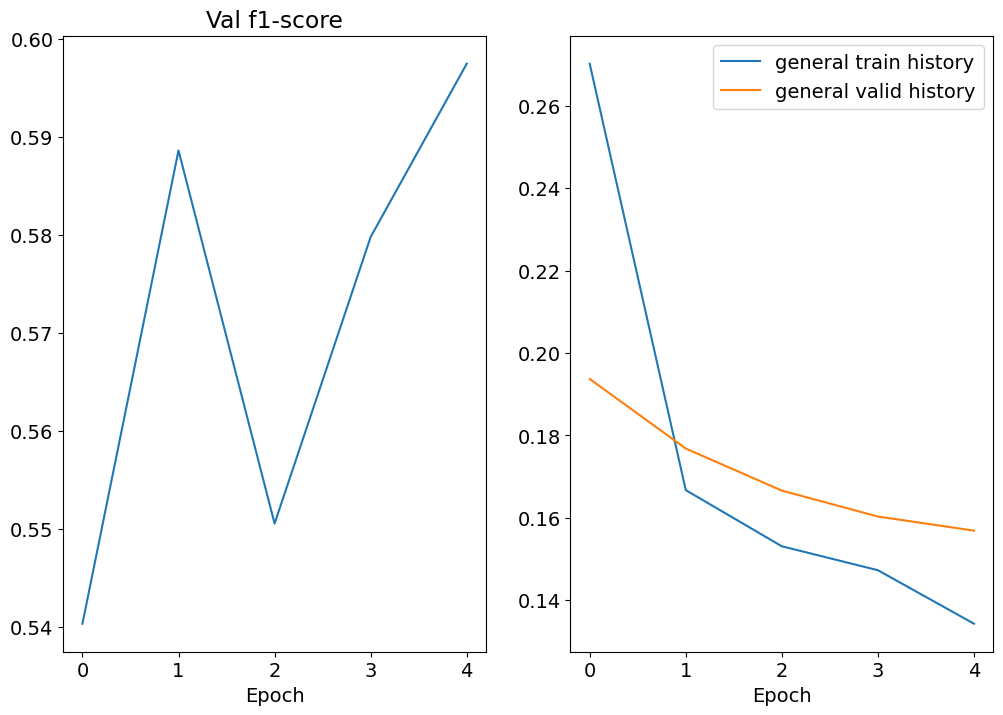

Epoch: 05 | Time: 9m 48s
	Train Loss: 0.134
	 Val. Loss: 0.157 |  Val. F1: 0.597


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [ ]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.9382022471910112,0.43832020997375326,0.5974955277280858


### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

In [ ]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph only

In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)

In [ ]:
idx_bound = 5
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)


 <s> iran , country , iran iran , replaces , pahlavi dynasty pahlavi dynasty , replaced by , iran </s> ruhollah khomeini ' s return to iran </s> , country , pahlavi dynasty </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 <s> iran , described by source , jewish encyclopedia of brockhaus and efron iran , country , iran letter , described by source , jewish encyclopedia of brockhaus and efron letter , subclass of , written work the book of healing , country of origin , iran the book of healing , instance of , written work </s> ruhollah khome

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

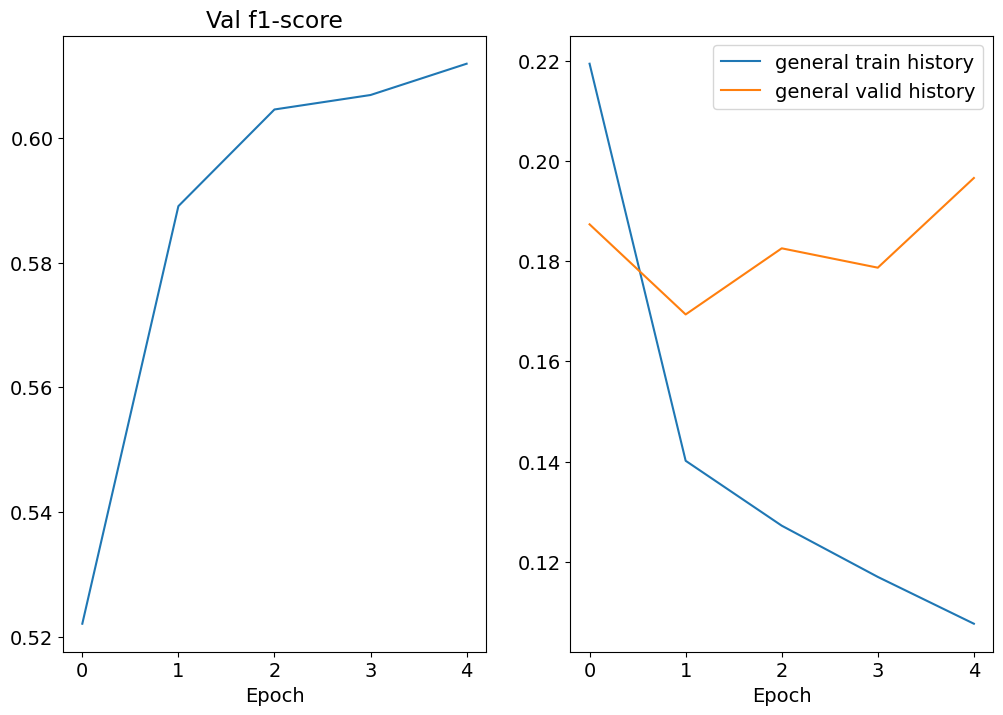

Epoch: 05 | Time: 9m 44s
	Train Loss: 0.108
	 Val. Loss: 0.197 |  Val. F1: 0.612


In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_only_clf", device)

In [ ]:

bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_only_clf.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.7916666666666666,0.49868766404199477,0.6119162640901772


### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,label,linearized_graph,true_y,prediction
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Clash of Kings </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> A Feast for Crows </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
2,2,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Fear and Loathing in Las Vegas,Q1213715,Q772435,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q772435', 'id': 1, 'label': 'Fear and Loathing in Las Vegas'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> Fear and Loathing in Las Vegas </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
3,3,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,In Cold Blood,Q1213715,Q1142887,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1142887', 'id': 1, 'label': 'In Cold Blood'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"United States, country, United States </s> In Cold Blood </s>, country of origin, United States A Time to Kill, country of origin, United States",0.0,0
4,4,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,Into the Woods,Q1213715,Q1118244,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1118244', 'id': 1, 'label': 'Into the Woods'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}",0.0,"

In [ ]:
test_pred_path = "test_pred_linearized_graph_only_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)